In [6]:
import os
import sys
import argparse
import numpy as np
import coco
import utils
import model as modellib
from classes import get_class_names, InferenceConfig
from ast import literal_eval as make_tuple
import imageio
import visualize_labelmod
from contextlib import closing
from videosequence import VideoSequence

In [7]:
# Creates a color layer and adds Gaussian noise.
# For each pixel, the same noise value is added to each channel
# to mitigate hue shfting.


def create_noisy_color(image, color):
    color_mask = np.full(shape=(image.shape[0], image.shape[1], 3),
                         fill_value=color)

    noise = np.random.normal(0, 25, (image.shape[0], image.shape[1]))
    noise = np.repeat(np.expand_dims(noise, axis=2), repeats=3, axis=2)
    mask_noise = np.clip(color_mask + noise, 0., 255.)
    return mask_noise


# Helper function to allow both RGB triplet + hex CL input

def string_to_rgb_triplet(triplet):

    if '#' in triplet:
        # http://stackoverflow.com/a/4296727
        triplet = triplet.lstrip('#')
        _NUMERALS = '0123456789abcdefABCDEF'
        _HEXDEC = {v: int(v, 16)
                   for v in (x + y for x in _NUMERALS for y in _NUMERALS)}
        return (_HEXDEC[triplet[0:2]], _HEXDEC[triplet[2:4]],
                _HEXDEC[triplet[4:6]])

    else:
        # https://stackoverflow.com/a/9763133
        triplet = make_tuple(triplet)
        return triplet

In [2]:
def person_blocker(args):
    
    # Required to load model, but otherwise unused
    ROOT_DIR = os.getcwd()
    COCO_MODEL_PATH = args.model or os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

    MODEL_DIR = os.path.join(ROOT_DIR, "logs")  # Required to load model

    if not os.path.exists(COCO_MODEL_PATH):
        utils.download_trained_weights(COCO_MODEL_PATH)

    # Load model and config
    config = InferenceConfig()
    model = modellib.MaskRCNN(mode="inference",
                              model_dir=MODEL_DIR, config=config)
    model.load_weights(COCO_MODEL_PATH, by_name=True)

    # Start reading the frames
    reader = imageio.get_reader(args.image)
    vlen = len(reader)
    
    for i, image in enumerate(reader):
    
        # Output frame number
        print(str(i)+"/"+str(vlen))
        
        # Create masks for all objects
        results = model.detect([image], verbose=0)
        r = results[0]

        if args.labeled:
            position_ids = [''.format(x)
                            for x in range(r['class_ids'].shape[0])]
            outstr = "output/labeled{:06d}.jpg".format(i)
            visualize_labelmod.display_instances(image, 
                                                 r['rois'],
                                                 r['masks'], 
                                                 r['class_ids'],
                                                 get_class_names(), 
                                                 position_ids, 
                                                 selected_class = args.selected_class, 
                                                 outname = outstr)
            continue

        # Filter masks to only the selected objects
        objects = np.array(args.objects)

        # Object IDs:
        if np.all(np.chararray.isnumeric(objects)):
            object_indices = objects.astype(int)
        # Types of objects:
        else:
            selected_class_ids = np.flatnonzero(np.in1d(get_class_names(),
                                                        objects))
            object_indices = np.flatnonzero(
                np.in1d(r['class_ids'], selected_class_ids))

        mask_selected = np.sum(r['masks'][:, :, object_indices], axis=2)

        # Replace object masks with noise
        mask_color = string_to_rgb_triplet(args.color)
        image_masked = image.copy()
        noisy_color = create_noisy_color(image, mask_color)
        image_masked[mask_selected > 0] = noisy_color[mask_selected > 0]

        # Save masked frame
        imageio.imwrite("output/frame{:06d}.jpg".format(i), image_masked)


if __name__ == '__main__':
    parser = argparse.ArgumentParser(
        description='Person Blocker - Automatically "block" people '
                    'in video using a neural network.')
    parser.add_argument('-i', '--image',  help='Video file name.',
                        required=False)
    parser.add_argument(
        '-m', '--model',  help='path to COCO model', default=None)
    parser.add_argument('-o',
                        '--objects', nargs='+',
                        help='object(s)/object ID(s) to block. ' +
                        'Use the -names flag to print a list of ' +
                        'valid objects',
                        default='person')
    parser.add_argument('-c',
                        '--color', nargs='?', default='(255, 255, 255)',
                        help='color of the "block"')
    parser.add_argument('-l',
                        '--labeled', dest='labeled',
                        action='store_true',
                        help='generate labeled image instead')
    parser.add_argument('-n',
                        '--names', dest='names',
                        action='store_true',
                        help='prints class names and exits.')
    parser.add_argument('-s', '--selected_class', help="If labels selected, which class to display",
                       required = False)
    parser.set_defaults(labeled=False, names=False, selected_class = None)
    args = parser.parse_args()

    if args.names:
        print(get_class_names())
        sys.exit()

    person_blocker(args)

usage: ipykernel_launcher.py [-h] [-i IMAGE] [-m MODEL]
                             [-o OBJECTS [OBJECTS ...]] [-c [COLOR]] [-l] [-n]
                             [-s SELECTED_CLASS]
ipykernel_launcher.py: error: unrecognized arguments: -f /run/user/1000/jupyter/kernel-7b9e5ce8-f106-49da-854a-e3a759f411ff.json


SystemExit: 2

/home/manuel/py_virtualenv/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2918: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
# Required to load model, but otherwise unused
ROOT_DIR = os.getcwd()
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

MODEL_DIR = os.path.join(ROOT_DIR, "logs")  # Required to load model

if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Load model and config
config = InferenceConfig()
model = modellib.MaskRCNN(mode="inference",
                          model_dir=MODEL_DIR, config=config)
model.load_weights(COCO_MODEL_PATH, by_name=True)

# Start reading the frames
reader = imageio.get_reader("input/citython.jpg")
results = model.detect(reader, verbose=0)
r = results[0]

TypeError: integer argument expected, got float

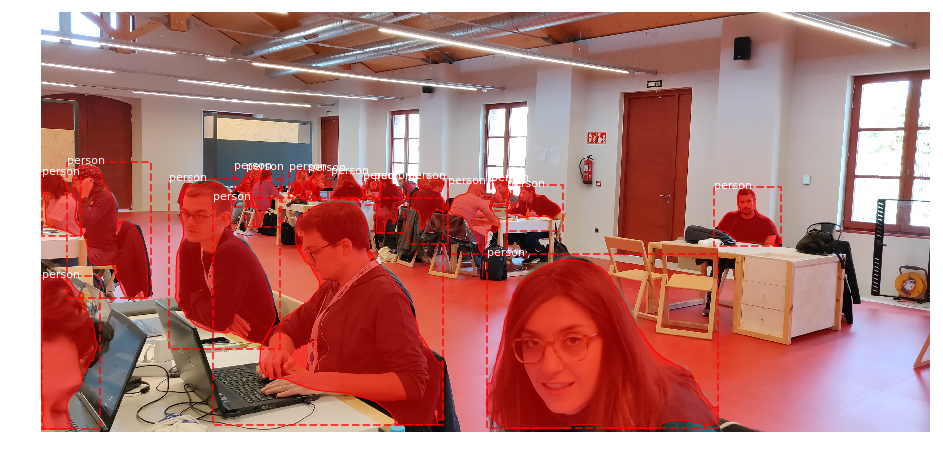

In [9]:
outr = None
for i, image in enumerate(reader):

    # Create masks for all objects
    results = model.detect([image], verbose=0)
    r = results[0]
    outr = r
    
    position_ids = [''.format(x)
                    for x in range(r['class_ids'].shape[0])]
    outstr = "output/citythontest.jpg"
    visualize_labelmod.display_instances(image, 
                                         r['rois'],
                                         r['masks'], 
                                         r['class_ids'],
                                         get_class_names(), 
                                         position_ids, 
                                         selected_class = "person", 
                                         outname = outstr)


In [8]:
position_ids

NameError: name 'position_ids' is not defined

In [15]:
sum(outr["class_ids"] == 1)

18

In [20]:
y = np.bincount(outr["class_ids"])
ii = np.nonzero(y)[0]
print(list(zip(ii, y[ii])))


[(1, 18), (57, 5), (61, 1), (64, 2)]


array([ 1, 57, 61, 64])

In [ ]:
# Required to load model, but otherwise unused
ROOT_DIR = os.getcwd()
COCO_MODEL_PATH = args.model or os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

MODEL_DIR = os.path.join(ROOT_DIR, "logs")  # Required to load model

if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Load model and config
config = InferenceConfig()
model = modellib.MaskRCNN(mode="inference",
                          model_dir=MODEL_DIR, config=config)
model.load_weights(COCO_MODEL_PATH, by_name=True)

# Start reading the frames
reader = imageio.get_reader("input/citython.jpg")
results = model.detect([image], verbose=0)
r = results[0]



vlen = len(reader)

for i, image in enumerate(reader):

    # Output frame number
    print(str(i)+"/"+str(vlen))

    # Create masks for all objects
    results = model.detect([image], verbose=0)
    r = results[0]

    if args.labeled:
        position_ids = [''.format(x)
                        for x in range(r['class_ids'].shape[0])]
        outstr = "output/labeled{:06d}.jpg".format(i)
        visualize_labelmod.display_instances(image, 
                                             r['rois'],
                                             r['masks'], 
                                             r['class_ids'],
                                             get_class_names(), 
                                             position_ids, 
                                             selected_class = args.selected_class, 
                                             outname = outstr)
        continue

    # Filter masks to only the selected objects
    objects = np.array(args.objects)

    # Object IDs:
    if np.all(np.chararray.isnumeric(objects)):
        object_indices = objects.astype(int)
    # Types of objects:
    else:
        selected_class_ids = np.flatnonzero(np.in1d(get_class_names(),
                                                    objects))
        object_indices = np.flatnonzero(
            np.in1d(r['class_ids'], selected_class_ids))

    mask_selected = np.sum(r['masks'][:, :, object_indices], axis=2)

    # Replace object masks with noise
    mask_color = string_to_rgb_triplet(args.color)
    image_masked = image.copy()
    noisy_color = create_noisy_color(image, mask_color)
    image_masked[mask_selected > 0] = noisy_color[mask_selected > 0]

    # Save masked frame
    imageio.imwrite("output/frame{:06d}.jpg".format(i), image_masked)


if __name__ == '__main__':
    parser = argparse.ArgumentParser(
        description='Person Blocker - Automatically "block" people '
                    'in video using a neural network.')
    parser.add_argument('-i', '--image',  help='Video file name.',
                        required=False)
    parser.add_argument(
        '-m', '--model',  help='path to COCO model', default=None)
    parser.add_argument('-o',
                        '--objects', nargs='+',
                        help='object(s)/object ID(s) to block. ' +
                        'Use the -names flag to print a list of ' +
                        'valid objects',
                        default='person')
    parser.add_argument('-c',
                        '--color', nargs='?', default='(255, 255, 255)',
                        help='color of the "block"')
    parser.add_argument('-l',
                        '--labeled', dest='labeled',
                        action='store_true',
                        help='generate labeled image instead')
    parser.add_argument('-n',
                        '--names', dest='names',
                        action='store_true',
                        help='prints class names and exits.')
    parser.add_argument('-s', '--selected_class', help="If labels selected, which class to display",
                       required = False)
    parser.set_defaults(labeled=False, names=False, selected_class = None)
    args = parser.parse_args()

    if args.names:
        print(get_class_names())
        sys.exit()

    person_blocker(args)

In [2]:



reader = imageio.get_reader("input/citython.jpg")
results = model.detect([image], verbose=0)
r = results[0]

NameError: name 'imageio' is not defined